# Image Captioning

The Microsoft **C**ommon **O**bjects in **CO**ntext (MS COCO) dataset is a large-scale dataset for scene understanding.  The dataset is commonly used to train and benchmark object detection, segmentation, and captioning algorithms.  

You can read more about the dataset on the [website](http://cocodataset.org/#home) or in the [research paper](https://arxiv.org/pdf/1405.0312.pdf).

In this project, you will use the dataset of image-caption pairs to train a CNN-RNN model to automatically generate caption given the images

<img src = "images/encoder-decoder.png" width = 800>

In [4]:
# !pip install nltk
! pip install pycocoevalcap

    100% |████████████████████████████████| 104.3MB 444kB/s eta 0:00:01   14% |████▋                           | 14.9MB 33.0MB/s eta 0:00:03
  Running setup.py bdist_wheel for pycocotools ... done
  Stored in directory: /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e
Successfully built pycocotools


In [5]:
import os
import sys
# initialize COCO API for instance annotations
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import requests
import time
import numpy as np
import skimage.io as io #scikit-image.io Reading, saving, and displaying images and video.
import matplotlib.pyplot as plt
import nltk
from collections import Counter
# from model import EncoderCNN, DecoderRNN
import math
#pytorch libraries
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torchvision import transforms, models
from vocabulary import Vocabulary
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
import pickle
import os.path
nltk.download('punkt')
# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
cuda


## Step 1 - Reading Dataset

### 1.1 Initialize the COCO API

We begin by initializing the [COCO API](https://github.com/cocodataset/cocoapi) that you will use to obtain the data.

In [5]:
dataDir = '/opt/cocoapi'
dataType = 'val2014'
#getting images
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)
# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)
# coco.anns is a dictionary which saves for each ann_id - segmentation, bbox, image_id etc
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=7.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


### 1.2 Plot a Sample Image
Next, we plot a random image from the dataset, along with its five corresponding captions.

http://images.cocodataset.org/val2014/COCO_val2014_000000319221.jpg


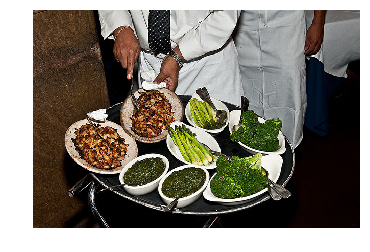

a tray filled with assorted plates and bowls, most with veggies in it
The people are preparing the food on the dish.
A man preparing food on top of a large metal pan.
A waiter presents a tray with several dishes.  
A man serves food from plates of meat and vegetables.


In [6]:
#pick a random image and obtain the corresponding URL
#select a random annotation id like 76807
ann_id = np.random.choice(ids)
#gets the respective image id for the annotation_id
img_id = coco.anns[ann_id]['image_id']
#loadImgs pulls the image information like url, height, weight
img = coco.loadImgs(img_id)[0]
#url of the image
url = img['coco_url']
# print URL and visualize corresponding image
print(url)
#loads the 3-d np.array for the image 
I = io.imread(url)
#plot the image
plt.axis('off')
plt.imshow(I)
plt.show()
#load with img_id captions for this image 
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Step 2: Preparing Dataset

### 2.1 Explore the Data Loader

The `get_loader` function takes as input a number of arguments 
1. **`transform`** - an [image transform](http://pytorch.org/docs/master/torchvision/transforms.html) specifying how to pre-process the images and convert them to PyTorch tensors before using them as input to the CNN encoder.  For now, you are encouraged to keep the transform as provided in `transform_train`.  You will have the opportunity later to choose your own image transform to pre-process the COCO images.
2. **`mode`** - one of `'train'` (loads the training data in batches) or `'test'` (for the test data). We will say that the data loader is in training or test mode, respectively.  While following the instructions in this notebook, please keep the data loader in training mode by setting `mode='train'`.
3. **`batch_size`** - determines the batch size.  When training the model, this is number of image-caption pairs used to amend the model weights in each training step.
4. **`vocab_threshold`** - the total number of times that a word must appear in the in the training captions before it is used as part of the vocabulary.  Words that have fewer than `vocab_threshold` occurrences in the training captions are considered unknown words. 
5. **`vocab_from_file`** - a Boolean that decides whether to load the vocabulary from file.  

In [7]:
class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))
        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]
        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [8]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'val':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/val2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_val2014.json')
    if mode == 'test':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)
    if mode == 'train' or mode == 'val':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train' or self.mode == 'val':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
            
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train' or self.mode == 'val':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']
            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)
            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()
            # return pre-processed image and caption tensors
            return image, caption
        # obtain image if in test mode
        else:
            path = self.paths[index]
            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train'or self.mode == 'val':
            return len(self.ids)
        else:
            return len(self.paths)

As you saw, in order to convert a token to its corresponding integer, we call `data_loader.dataset.vocab` as a function.  The details of how this call works can be explored in the `__call__` method in the `Vocabulary` class in **vocabulary.py**.  

```python
def __call__(self, word):
    if not word in self.word2idx:
        return self.word2idx[self.unk_word]
    return self.word2idx[word]
```

The `word2idx` instance variable is a Python [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) that is indexed by string-valued keys (mostly tokens obtained from training captions).  For each key, the corresponding value is the integer that the token is mapped to in the pre-processing step.

As you will see if you examine the code in **vocabulary.py**, the `word2idx` dictionary is created by looping over the captions in the training dataset.  If a token appears no less than `vocab_threshold` times in the training set, then it is added as a key to the dictionary and assigned a corresponding unique integer.  You will have the option later to amend the `vocab_threshold` argument when instantiating your data loader.  Note that in general, **smaller** values for `vocab_threshold` yield a **larger** number of tokens in the vocabulary.
There are also a few special keys in the `word2idx` dictionary.  You are already familiar with the special start word (`"<start>"`) and special end word (`"<end>"`).  There is one more special token, corresponding to unknown words (`"<unk>"`).  All tokens that don't appear anywhere in the `word2idx` dictionary are considered unknown words.  In the pre-processing step, any unknown tokens are mapped to the integer `2`.

The final thing to mention is the `vocab_from_file` argument that is supplied when creating a data loader.  To understand this argument, note that when you create a new data loader, the vocabulary (`data_loader.dataset.vocab`) is saved as a [pickle](https://docs.python.org/3/library/pickle.html) file in the project folder, with filename `vocab.pkl`.

### 2.2 Use the Data Loader to Obtain Batches

The captions in the dataset vary greatly in length.  You can see this by examining `data_loader.dataset.caption_lengths`, a Python list with one entry for each training caption (where the value stores the length of the corresponding caption).  

The majority of captions have length 10.  Likewise, very short and very long captions are quite rare.  

To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset).  Then, we retrieve a batch of size `batch_size` of image-caption pairs, where all captions have the sampled length.  This approach for assembling batches matches the procedure in [this paper](https://arxiv.org/pdf/1502.03044.pdf) and has been shown to be computationally efficient without degrading performance.

The `get_train_indices` method in the `CoCoDataset` class first samples a caption length, and then samples `batch_size` indices corresponding to training data points with captions of that length.  These indices are stored below in `indices`.

These indices are supplied to the data loader, which then is used to retrieve the corresponding data points.  The pre-processed images and captions in the batch are stored in `images` and `captions`.

In the next steps, we focus on learning how to specify a CNN-RNN architecture in PyTorch, towards the goal of image captioning.

## Step 3: Model Setup

### 3.1 Experiment with the CNN Encoder

In [9]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_dim = hidden_size
        self.embed = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size,vocab_size)
        self.init_weights()
        
    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1,0.1)
        self.linear.weight.data.uniform_(-0.1,0.1)
        self.linear.bias.data.fill_(0)
        
    def forward(self, features, captions):
        # torch.Size([32, 512]) torch.Size([32, 32])
        captions = captions[:, :-1] 
        embedded = self.embed(captions)
        # Features, embedded: torch.Size([32, 512]) torch.Size([32, 31, 512])
        embedded = torch.cat((features.unsqueeze(1),embedded),1)
        # Features_unsquueze: torch.Size([32, 1, 512])
        lstm_out,self.hidden = self.lstm(embedded)
        # Lstm_output: torch.Size([32, 32, 512])
        out = self.linear(lstm_out)
        # Output: torch.Size([32, 32, 9955])
        return out

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        result = []
        for i in range(max_len):
            output,states = self.lstm(inputs,states)
            output = self.linear(output.squeeze(1))
            _, predicted = torch.max(output, 1)
            result.append(predicted.item())
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        return result

Run the code cell below to instantiate the CNN encoder in `encoder`.  

The pre-processed images from the batch in **Step 2** of this notebook are then passed through the encoder, and the output is stored in `features`.

The encoder that we provide to you uses the pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images.  The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding.

You are welcome (and encouraged) to amend the encoder in **model.py**, to experiment with other architectures.  In particular, consider using a [different pre-trained model architecture](http://pytorch.org/docs/master/torchvision/models.html).  You may also like to [add batch normalization](http://pytorch.org/docs/master/nn.html#normalization-layers).  

Your `EncoderCNN` class must take `embed_size` as an input argument, which will also correspond to the dimensionality of the input to the RNN decoder that you will implement in Step 4.  When you train your model in the next notebook in this sequence , you are welcome to tweak the value of `embed_size`.

If you decide to modify the `EncoderCNN` class, save **model.py** and re-execute the code cell above.  If the code cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  The assert statements ensure that `features` is a PyTorch tensor with shape `[batch_size, embed_size]`.

### 3.1 Implement the RNN Decoder

Your decoder will be an instance of the `DecoderRNN` class and must accept as input:
- the PyTorch tensor `features` containing the embedded image features (outputted in Step 3, when the last batch of images from Step 2 was passed through `encoder`), along with
- a PyTorch tensor corresponding to the last batch of captions (`captions`) from Step 2.

Note that the way we have written the data loader should simplify your code a bit.  In particular, every training batch will contain pre-processed captions where all have the same length (`captions.shape[1]`), so **you do not need to worry about padding**.

Although you will test the decoder using the last batch that is currently stored in the notebook, your decoder should be written to accept an arbitrary batch (of embedded image features and pre-processed captions [where all captions have the same length]) as input.  

In the code cell below, `outputs` should be a PyTorch tensor with size `[batch_size, captions.shape[1], vocab_size]`.  Your output should be designed such that `outputs[i,j,k]` contains the model's predicted score, indicating how likely the `j`-th token in the `i`-th caption in the batch is the `k`-th token in the vocabulary.  Later, we provide code to supply these scores to the [`torch.nn.CrossEntropyLoss`](http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) optimizer in PyTorch.

## Step 4: Training

### 4.1 Training Setup
In this part you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure. The values you set now will be used when training your model below.

### Setting Parameters
Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance! 

### Trainable parameters
The parameters in the Encoder are already trained as they are from the pretrained model ResNet-50 except for the last layer which we train for pretrained models to fit our needs. Also, we need to train all the parameters for the RNN so all the parameters where choosen.

### Optimizer
Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).
Used Adam optimiser as Adam is the most commonly used and the best performing optimizer.Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum.

In [10]:
## TODO #1: Select appropriate values for the Python variables below.
batch_size = 32         # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = False    # if True, load existing vocab file
embed_size = 512    # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 1000          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)
# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)
# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.to(device)
decoder.to(device)
# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
#Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())
#Define the optimizer.
optimizer = optim.Adam(params, lr=0.001)
# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.89s)
creating index...


  0%|          | 873/414113 [00:00<01:34, 4373.19it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:35<00:00, 4317.78it/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 72653109.13it/s]


In [40]:
img, cap = next(iter(data_loader))
print(img.shape)
cap.shape

torch.Size([32, 3, 224, 224])


torch.Size([32, 14])

### 4.2 Train your Model

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

In [2]:
# Open the training log file.
f = open(log_file, 'w')
old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})
for epoch in range(1, num_epochs+1):
    for i_step in range(1, total_step+1):
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        # Obtain the batch.
        images, captions = next(iter(data_loader))
        # Move batch of images and captions to GPU if CUDA is available.
        images, captions = images.to(device), captions.to(device)
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        #outputs,Captions: torch.Size([1024, 9955]) torch.Size([1024])
        # Backward pass.
        loss.backward()
        # Update the parameters in the optimizer.
        optimizer.step()
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.2f, Perplexity: %5.2f, Percent: %.2f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()), i_step/float(total_step))
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))
# Close the training log file.
f.close()

NameError: name 'log_file' is not defined

## Step 5: Inference

In [11]:
#Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
# Create the data loader.
test_data_loader = get_loader(transform=transform_test, mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [12]:
num_epochs = 1

In [13]:
#Specify the saved models to load.
encoder_file = 'encoder-'+str(num_epochs)+'.pkl'
decoder_file = 'decoder-'+str(num_epochs)+'.pkl'
#Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512
#The size of the vocabulary.
vocab_size = len(test_data_loader.dataset.vocab)
# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()
# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

def clean_sentence(output):
    sentence = ' '.join([test_data_loader.dataset.vocab.idx2word[idx] for idx in output[len(output) - output[::-1].index(0) : output.index(1)]])
    return sentence

def get_prediction():
    orig_image, image = next(iter(test_data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

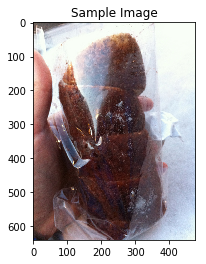

a person holding a banana in their hand .


In [14]:
get_prediction()

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

In [15]:
# Build data loader.
val_data_loader = get_loader(transform=transform_train,
                         mode='val'
                        )
#json-format - [{"image_id": 391895, "caption": "Man riding a motor bike on a dirt road on the countryside."}, 
#{"image_id": 522418, "caption": "A woman wearing a net on her head cutting a cake."}]

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 849/202654 [00:00<00:47, 4261.07it/s]

Done (t=0.41s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:46<00:00, 4358.11it/s]


In [47]:
def get_prediction():
    image, captions = next(iter(val_data_loader))
    captions = list(captions[0].numpy())
    actuals = clean_sentence(captions)
    image = image.to(device)
    
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence, actuals)

In [48]:
get_prediction()

a red fire hydrant with a blue top a artistic photograph of a scooter in an alley .


In [53]:
! git clone https://github.com/tylin/coco-caption.git

Cloning into 'coco-caption'...
remote: Enumerating objects: 736, done.
remote: Total 736 (delta 0), reused 0 (delta 0), pack-reused 736
Receiving objects: 100% (736/736), 130.04 MiB | 49.41 MiB/s, done.
Resolving deltas: 100% (390/390), done.
Checking connectivity... done.


In [56]:
! ls

0_Dataset.ipynb				      data_loader.py
0_Dataset-zh.ipynb			      filelist.txt
1_Preliminaries.ipynb			      ImageCaptioningCOCO_2.ipynb
1_Preliminaries-zh.ipynb		      ImageCaptioningCOCO.ipynb
2_Training.html				      images
2_Training.ipynb			      model.py
2_Training-zh.ipynb			      models
3_Inference.html			      project2.zip
3_Inference.ipynb			      __pycache__
3_Inference-zh.ipynb			      training_log.txt
4_Zip Your Project Files and Submit.ipynb     Untitled.ipynb
4_Zip Your Project Files and Submit-zh.ipynb  vocab.pkl
coco-caption				      vocabulary.py


In [6]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')